In [1]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sam import SAM  # Ensure SAM is installed or implemented (details below)
import inspect

NOTES: 
- To run this code you need to import the SAM class from https://github.com/davda54/sam
- Due to very long running times and hardware contraints, we manually fine-tuned hyperparameters in several notebooks to speed up our progress. The conclusions we present at the end of this notebook are gathered from training different models with different hyper-parameters configurations in several jupyter notebooks. However, with this submission we are just uploading two notebooks, this one contains models 2 and 3 presented on the poster and the other notebook contains model 1 (the baseline model)

# Data Preprocessing

In this notebook, we decided to train our model with the whole training dataset provided by datasets.CIFAR100(train=True) instead of dividing it in training and validation (as we did in several other notebooks) to provide the model with more samples to learn from. 

In [ ]:
# Define preprocessing transformations
# CIFAR-100 images were resized from 32x32 to 224x224 pixels to match ImageNet-trained EfficientNetB0 model
# Images were normalized to match ImageNet's mean and standard deviation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Directly resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # Standard normalization
])

batch_size=64

# Load the CIFAR-100 dataset and divide into training and testing
train_dataset = datasets.CIFAR100(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR100(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


# Model 2

###  Fine-tuned EfficientNetB0 model trained on the CIFAR-100 dataset.

1. EfficientNetB0's classifier layer was adjusted to have 100 output neurons for 100 classes in the CIFAR-100 dataset instead of the 1000 neurons for classifying images from ImageNet.
2. We freeze the first three blocks of the EfficientNetB0 model to use these pre-trained features (containing information such as edges or texture), allowing the model concentrate on adapting the higher, task-specific layers to the new dataset.
3. Hyperparamters used: 
- Based optimizer: Adam
- SAM optimizer to improve generalization
- Starting learning rate: 0.001
- Learning rate scheduler: StepLR with a step size of 5 and gamma 0.1 (drops the LR by a factor of 0.1 each 5 epochs)
- L2 with a weight decay of 1e-4 to address overfitting.
- Loss Function: CrossEntropy Loss
- Epochs: 15

In [ ]:
# Load EfficientNet
num_classes = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')      # Using EfficientNet-B0
num_features = efficientnet.classifier[1].in_features               # Input features to the classifier layer
efficientnet.classifier[1] = nn.Linear(num_features, num_classes)   # Replace for CIFAR-100
nn.init.xavier_uniform_(efficientnet.classifier[1].weight)
efficientnet.classifier[1].bias.data.fill_(0.0)

# Number of blocks to freeze (e.g., first 3 blocks)
num_blocks_to_freeze = 3

# Iterate over the features and freeze the first few blocks
for idx, block in enumerate(efficientnet.features):
    if idx < num_blocks_to_freeze:  # Freeze the first `num_blocks_to_freeze` blocks
        for param in block.parameters():
            param.requires_grad = False
    else:
        break  # No need to iterate further once we've frozen the required blocks

# Verify which layers are frozen
for name, param in efficientnet.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

efficientnet.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()

# SAM Optimizer
base_optimizer = torch.optim.Adam  # Base optimizer for SAM
optimizer = SAM(efficientnet.parameters(), base_optimizer, lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


# Training Loop with SAM
epochs = 15
train_accuracy_per_epoch = []
train_loss_per_epoch = []

for epoch in range(epochs):
    efficientnet.train()
    epoch_loss = 0        
    n_correct = 0
    n_examples = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = efficientnet(images)
        loss = criterion(outputs, labels)

        # First step of SAM
        loss.backward()
        optimizer.first_step(zero_grad=True)

        # Second step of SAM
        criterion(efficientnet(images), labels).backward()
        optimizer.second_step(zero_grad=True)

        # Convert logits to predictions
        predicted_labels = torch.argmax(outputs, dim=1)
        n_correct += (predicted_labels == labels).sum().item()
        epoch_loss += loss.item()
        n_examples += labels.size(0)

    # Calculate and store metrics for this epoch
    train_accuracy_per_epoch.append(n_correct / n_examples)
    train_loss_per_epoch.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}: Train Accuracy: {train_accuracy_per_epoch[-1]:.4f}, Loss: {train_loss_per_epoch[-1]:.4f}")
    # Update the learning rate
    scheduler.step()
 
    # Print current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}, Learning Rate: {current_lr:.6f}")

print("EfficientNet fine-tuning with SAM complete.")

features.0.0.weight: requires_grad = False
features.0.1.weight: requires_grad = False
features.0.1.bias: requires_grad = False
features.1.0.block.0.0.weight: requires_grad = False
features.1.0.block.0.1.weight: requires_grad = False
features.1.0.block.0.1.bias: requires_grad = False
features.1.0.block.1.fc1.weight: requires_grad = False
features.1.0.block.1.fc1.bias: requires_grad = False
features.1.0.block.1.fc2.weight: requires_grad = False
features.1.0.block.1.fc2.bias: requires_grad = False
features.1.0.block.2.0.weight: requires_grad = False
features.1.0.block.2.1.weight: requires_grad = False
features.1.0.block.2.1.bias: requires_grad = False
features.2.0.block.0.0.weight: requires_grad = False
features.2.0.block.0.1.weight: requires_grad = False
features.2.0.block.0.1.bias: requires_grad = False
features.2.0.block.1.0.weight: requires_grad = False
features.2.0.block.1.1.weight: requires_grad = False
features.2.0.block.1.1.bias: requires_grad = False
features.2.0.block.2.fc1.weig

Epoch 1/15:   0%|          | 0/782 [00:00<?, ?it/s]/home/csaxon/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/15: 100%|██████████| 782/782 [12:29<00:00,  1.04it/s]
/home/csaxon/venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1: Train Accuracy: 0.6106, Loss: 1.4041
Epoch 1, Learning Rate: 0.001000


Epoch 2/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 2: Train Accuracy: 0.7583, Loss: 0.8032
Epoch 2, Learning Rate: 0.001000


Epoch 3/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 3: Train Accuracy: 0.8051, Loss: 0.6360
Epoch 3, Learning Rate: 0.001000


Epoch 4/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 4: Train Accuracy: 0.8271, Loss: 0.5527
Epoch 4, Learning Rate: 0.001000


Epoch 5/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 5: Train Accuracy: 0.8463, Loss: 0.4924
Epoch 5, Learning Rate: 0.000100


Epoch 6/15: 100%|██████████| 782/782 [12:26<00:00,  1.05it/s]


Epoch 6: Train Accuracy: 0.9326, Loss: 0.2284
Epoch 6, Learning Rate: 0.000100


Epoch 7/15: 100%|██████████| 782/782 [12:26<00:00,  1.05it/s]


Epoch 7: Train Accuracy: 0.9625, Loss: 0.1359
Epoch 7, Learning Rate: 0.000100


Epoch 8/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 8: Train Accuracy: 0.9748, Loss: 0.0999
Epoch 8, Learning Rate: 0.000100


Epoch 9/15: 100%|██████████| 782/782 [12:24<00:00,  1.05it/s]


Epoch 9: Train Accuracy: 0.9812, Loss: 0.0769
Epoch 9, Learning Rate: 0.000100


Epoch 10/15: 100%|██████████| 782/782 [12:26<00:00,  1.05it/s]


Epoch 10: Train Accuracy: 0.9860, Loss: 0.0630
Epoch 10, Learning Rate: 0.000010


Epoch 11/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 11: Train Accuracy: 0.9914, Loss: 0.0463
Epoch 11, Learning Rate: 0.000010


Epoch 12/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 12: Train Accuracy: 0.9917, Loss: 0.0434
Epoch 12, Learning Rate: 0.000010


Epoch 13/15: 100%|██████████| 782/782 [12:25<00:00,  1.05it/s]


Epoch 13: Train Accuracy: 0.9931, Loss: 0.0396
Epoch 13, Learning Rate: 0.000010


Epoch 14/15: 100%|██████████| 782/782 [12:26<00:00,  1.05it/s]


Epoch 14: Train Accuracy: 0.9933, Loss: 0.0383
Epoch 14, Learning Rate: 0.000010


Epoch 15/15: 100%|██████████| 782/782 [12:27<00:00,  1.05it/s]

Epoch 15: Train Accuracy: 0.9940, Loss: 0.0362
Epoch 15, Learning Rate: 0.000001
EfficientNet fine-tuning with SAM complete.


In [ ]:
# Validation part of the model
efficientnet.eval()  # Set model to evaluation mode
test_loss = 0
n_correct = 0
n_examples = 0

test_accuracy = 0

# Disable gradients for test
with torch.no_grad():  
    for examples, labels in tqdm(test_loader, desc="Validating"):

        # Forward pass
        logits = efficientnet(examples.to(device))  

        # Calculate loss
        loss = criterion(logits, labels.to(device))  
        
        # Convert logits to predictions
        predicted_labels = torch.argmax(logits, dim=1)
        n_correct += (predicted_labels == labels.to(device)).sum().item()
        test_loss += loss.item()
        n_examples += labels.size(0)

#  Ratio of correct predictions (n_correct) to the total number of examples processed (n_examples)
test_accuracy = n_correct / n_examples

# Average batch loss
print(f"Test Loss: {test_loss / len(test_loader):.4f}, test Accuracy: {test_accuracy:.2f}%")

Validating: 100%|██████████| 157/157 [00:47<00:00,  3.29it/s]

Test Loss: 0.6531, test Accuracy: 0.83%


Note: I forgot to multiply the test accuracy * 100 to get the percentage here, but the test accuracy is 83%

# Model 3

The convolutional layers of Model 2 were utilized to extract high-level features, replacing the model's classification layer with a RandomForest classifier for the task.

In [6]:
# Feature Extraction
efficientnet.classifier[1] = nn.Identity()  # Remove classifier layer

## Using fine-tuned model as a feature extractor

In [ ]:
efficientnet.eval()  # Set to evaluation mode
# Feature Extraction Function
def extract_features(dataloader, model):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            outputs = model(images)                         # Extract features
            outputs = outputs.view(outputs.size(0), -1)     # Flatten
            features.append(outputs.cpu().numpy())
            labels.append(targets.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

In [8]:
# Extract Features
train_features, train_labels = extract_features(train_loader, efficientnet)
test_features, test_labels = extract_features(test_loader, efficientnet)

print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")

# Train Features: (50000, 1280)
# Test Features: (10000, 1280)

Train Features: (50000, 1280), Train Labels: (50000,)
Test Features: (10000, 1280), Test Labels: (10000,)


## Train a Random Forest Model on the features extracted through the fine-tuned EfficientNetB0 model

In [10]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=30, min_samples_split=5)
rf.fit(train_features, train_labels)

train_predictions = rf.predict(train_features)
accuracy = accuracy_score(train_labels, train_predictions)
print(f"Train Accuracy: {accuracy:.4f}")
print("Random Forest training complete.")

Train Accuracy: 0.9998
Random Forest training complete.


In [11]:
# Test Random Forest
predictions = rf.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8163


We tried to perform Grid-Search trying different combinations of hyper-parameters on the RandomForest model, but we never could finish running these because of hardware contraints: Kernel kept crashing, running time was excessively long, etc.

In [ ]:
# # Train Random Forest
# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }
# grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=5)
# grid_search.fit(train_features, train_labels)
# print(f"Best Parameters: {grid_search.best_params_}")

# train_predictions = grid_search.predict(train_features)
# accuracy = accuracy_score(train_labels, train_predictions)
# print(f"Training Accuracy: {accuracy:.4f}")
# print("Random Forest training complete.")

# # Test Random Forest
# predictions = grid_search.predict(test_features)
# accuracy = accuracy_score(test_labels, predictions)
# print(f"Test Accuracy: {accuracy:.4f}")

# Conclusions

- Regularization techniques like weight decay (L2) and
dropout reduced overfitting, mainly in model 1.
- Model 1: 99% training, 94% validation accuracy. (on a separate notebook)
- Model 2: ~99% training, 83% test accuracy.
- Model 3: ~99% training, 81% test accuracy.
- Limited computational resources constrained model epochs and further improvements.
- EfficientNetB0 achieved ~83% test accuracy on CIFAR-100, surpassing ResNet18’s test accuracy on CIFAR-100 (~70%) due to its balanced scaling of width, depth, and resolution.
- ResNet18 performed well on CIFAR-10, likely due to its architectural design being well-suited for simpler datasets.
- The EfficientNetB0’s fully connected layer slightly outperformed RandomForest for classification.
- Fewer examples per class in CIFAR-100 increases the risk of overfitting compared to CIFAR-10
- In another notebook, we used Dropout in Combination with the SAM optimizer to imrpove generalization. As expected the training accuracy dropped, and also did the testing accuracy. An interesting result is that the training process was smoother (did not present sudden jumps). However, we believe that this is due to using another learning rate scheduler CosineAnnealingLR with T_max=30 & eta_min=1e-5, which allowed the learning rate to be adjusted in a smoother manner ultimately resulting in a more stable training process.

# Choice of a learning rate scheduler in training process

### Training process with CosineAnnealingLR
It appears more smooth and steady in comparison to using stepLR

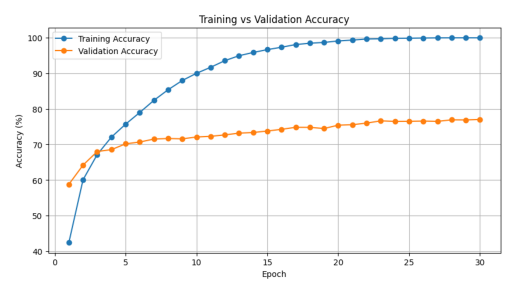

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image_path = 'training_vs_validation_accuracy_with_cosineSchedulerAndDropout.png'  # Replace with your image filename
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  
plt.show()


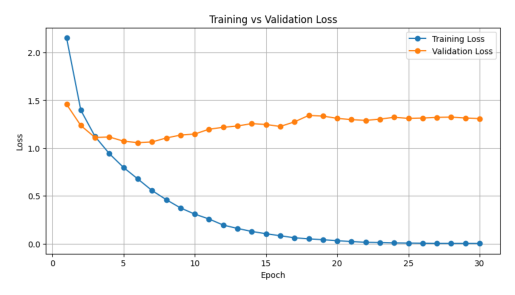

In [7]:
# Load the image
image_path = 'training_vs_validation_loss_with_cosineSchedulerAndDropout.png'  # Replace with your image filename
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  
plt.show()

### Training with StepLR

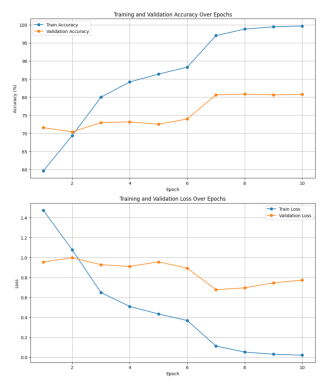

In [8]:
# Load the image
image_path = 'accuracy_and_loss_with_stepLR_and_nodropout.png'  # Replace with your image filename
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  
plt.show()

We can observed that the training process is smoother, but overfitting is still pretty evident. As stated before, fewer examples per class in CIFAR-100 increases the risk of overfitting compared to CIFAR-10. These results are evident in the testing accuracies obtained in model 1 (trained on CIFAR-10), and models 2 and 3 (trained on CIFAR-100).